# Zmrzlina po celý rok — plán výroby jako lineární program

**Co řešíme.** Máme odhad **měsíční poptávky** na příští rok. Chceme naplánovat měsíční výrobu tak,
abychom pokryli poptávku a **minimalizovali celkové náklady**:
- náklad na **změnu výroby** mezi dvěma po sobě jdoucími měsíci,
- náklad na **skladování** meziměsíčních zásob.

## Modelové předpoklady
- Poptávka měsíce $i$ je číslo $d_i$ [t].
- Proměnná $x_i$ je **výroba** v měsíci $i$ [t].
- Proměnná $s_i$ je **zásoba** na konci měsíce $i$ [t].
- Na začátku ledna: $s_0 = 0$ (žádná zásoba z minulého roku).
- **Rovnice toku**: co se vyrobí plus zásoba z minulého měsíce se buď prodá, nebo uloží:
  $$
  x_i + s_{i-1} - s_i = d_i, \quad i=1,\dots,12.
  $$
- Výroba a zásoba jsou nezáporné.
- Náklad na **změnu** je $c_\Delta$ Kč za 1 t změny výroby mezi $i-1$ a $i$.
  Přirozeně by byl výraz $c_\Delta \sum_{i=1}^{12} |x_i - x_{i-1}|$, což **není lineární**.

## „Trik s absolutní hodnotou“ → LP
Zavedeme dvě nezáporné proměnné $y_i$ a $z_i$, které představují **zvýšení** a **snížení** výroby:
$$
x_i - x_{i-1} = y_i - z_i,\qquad y_i \ge 0,\ z_i \ge 0.
$$
Pak platí $ |x_i - x_{i-1}| = y_i + z_i $ v optimu.  
Celkový náklad:
$$
\min\  c_\Delta \sum_{i=1}^{12}(y_i+z_i) + c_S \sum_{i=1}^{12} s_i .
$$
Tím dostáváme **lineární program**.

V následujících krocích:
1. Zadáme data (poptávky, ceny).
2. Postavíme LP v PuLP.
3. Vyřešíme a zkontrolujeme podmínky.
4. Vizualizujeme výrobu vs. poptávku, zásoby a změny výroby.
5. Provedeme **citlivostní analýzu** (sweep nákladů).


In [19]:
!pip -q install pulp pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp

plt.rcParams["figure.figsize"] = (8.5, 4.8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11


## Data a parametry

Níže je vektor poptávky `demand` v tunách pro měsíce I–XII.  
Hodnoty jsou opsané z grafu v učebnici v rozumné aproximaci (případně upravte podle vaší verze).
Parametry nákladů:
- `change_cost` … Kč za 1 t změny výroby mezi dvěma měsíci (v textu 1500 Kč/t),
- `holding_cost` … Kč za 1 t zásoby držené 1 měsíc (v textu 600 Kč/t).


In [20]:
# Měsíce I..XII
months = ["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII"]

# ≈Poptávka z obrázku [t] (EDITOVATELNÉ)
demand = [350, 320, 450, 650, 650, 540, 700, 690, 370, 450, 400, 650]

# Nákladové parametry (EDITOVATELNÉ)
change_cost  = 1500.0   # Kč/t změny výroby
holding_cost =  600.0   # Kč/t a měsíc

x0 = 0.0   # výroba "měsíc 0"
s0 = 0.0   # zásoba na začátku roku

df_d = pd.DataFrame({"měsíc": months, "poptávka[t]": demand})
df_d


měsíc  poptávka[t]
0      I          350
1     II          320
2    III          450
3     IV          650
4      V          650
5     VI          540
6    VII          700
7   VIII          690
8     IX          370
9      X          450
10    XI          400
11   XII          650

## Sestavení LP

Proměnné pro každý měsíc $i$:
- `x[i]` výroba [t], `s[i]` zásoba [t],
- `y[i]` zvýšení výroby, `z[i]` snížení výroby (trik na absolutní hodnotu).

Omezení:
- bilance: `x[i] + s[i-1] - s[i] = demand[i]`,
- definice změn: `x[i] - x[i-1] = y[i] - z[i]`,
- nezápornost: `x,s,y,z ≥ 0`,
- počátky: `x[-1]=x0`, `s[-1]=s0`.

Cíl:
$$
\min\  \texttt{change_cost}\cdot \sum (y_i+z_i) + \texttt{holding_cost}\cdot \sum s_i .
$$


In [21]:
def solve_icecream_lp(demand, change_cost=1500.0, holding_cost=600.0, x0=0.0, s0=0.0, sN=0.0, names=None, msg=False):
    n = len(demand)
    names = names or [f"M{i+1}" for i in range(n)]

    prob = pulp.LpProblem("IceCreamPlan", pulp.LpMinimize)

    x = pulp.LpVariable.dicts("x", range(n), lowBound=0)  # production
    s = pulp.LpVariable.dicts("s", range(n), lowBound=0)  # inventory (end of month)
    y = pulp.LpVariable.dicts("y", range(n), lowBound=0)  # increase
    z = pulp.LpVariable.dicts("z", range(n), lowBound=0)  # decrease

    # Objective
    prob += change_cost * pulp.lpSum(y[i] + z[i] for i in range(n)) + holding_cost * pulp.lpSum(s[i] for i in range(n))

    # Constraints per month
    for i in range(n):
        prev_x = x[i-1] if i > 0 else x0
        prev_s = s[i-1] if i > 0 else s0
        # balance
        prob += x[i] + prev_s - s[i] == demand[i], f"balance_{i}"
        # change decomposition
        prob += x[i] - prev_x == y[i] - z[i], f"change_{i}"

    prob += s[n-1] == sN, "end_stock"

    status_code = prob.solve(pulp.PULP_CBC_CMD(msg=msg))
    status = pulp.LpStatus[status_code]

    # Read results
    res = {
        "status": status,
        "x": np.array([x[i].value() for i in range(n)], dtype=float),
        "s": np.array([s[i].value() for i in range(n)], dtype=float),
        "y": np.array([y[i].value() for i in range(n)], dtype=float),
        "z": np.array([z[i].value() for i in range(n)], dtype=float),
        "obj": pulp.value(prob.objective),
        "names": names,
        "problem": prob
    }
    return res


## Řešení s náklady z textu

Získáme plán výroby `x`, zásoby `s`, změny `y,z` a celkový náklad.  
Ověříme:
- že $\sum (y_i+z_i) = \sum |x_i - x_{i-1}|$ (správnost lineární náhrady),
- že bilance dává přesně poptávku.


In [22]:
res = solve_icecream_lp(demand, change_cost, holding_cost, x0=x0, s0=s0, sN=0.0, names=months, msg=False)

print("Status:", res["status"])
print(f"Celkový náklad: {res['obj']:.0f} Kč")

# Tabulka výsledků
tab = pd.DataFrame({
    "měsíc": res["names"],
    "poptávka[t]": demand,
    "výroba x[t]": res["x"].round(2),
    "zásoba s[t]": res["s"].round(2),
    "zvýšení y[t]": res["y"].round(2),
    "snížení z[t]": res["z"].round(2),
})
tab


Status: Optimal
Celkový náklad: 1585750 Kč


měsíc  poptávka[t]  výroba x[t]  zásoba s[t]  zvýšení y[t]  snížení z[t]
0      I          350       350.00         0.00        350.00          0.00
1     II          320       350.00        30.00          0.00          0.00
2    III          450       433.33        13.33         83.33          0.00
3     IV          650       643.33         6.67        210.00          0.00
4      V          650       643.33         0.00          0.00          0.00
5     VI          540       643.33       103.33          0.00          0.00
6    VII          700       643.33        46.67          0.00          0.00
7   VIII          690       643.33         0.00          0.00          0.00
8     IX          370       467.50        97.50          0.00        175.83
9      X          450       467.50       115.00          0.00          0.00
10    XI          400       467.50       182.50          0.00          0.00
11   XII          650       467.50         0.00          0.00          0.00

In [23]:
# Kontroly "abs" triku a bilance
x = res["x"]
y, z = res["y"], res["z"]
s = res["s"]

abs_by_trick = (y + z).sum()
abs_real = np.abs(np.diff(np.r_[x0, x])).sum()

balance_ok = np.allclose(x + np.r_[s0, s[:-1]] - s, demand, atol=1e-6)

print(f"Σ(y+z) = {abs_by_trick:.2f},  Σ|Δx| = {abs_real:.2f}  → shoda:", np.isclose(abs_by_trick, abs_real))
print("Bilance v každém měsíci správně:", balance_ok)


Σ(y+z) = 819.17,  Σ|Δx| = 819.17  → shoda: True
Bilance v každém měsíci správně: True


## Grafy

- Sloupce: **výroba** vs. **poptávka**.
- Křivka: **zásoba** na konci měsíce.
- Druhý graf: **zvýšení/snížení** výroby (kladné/záporné změny).


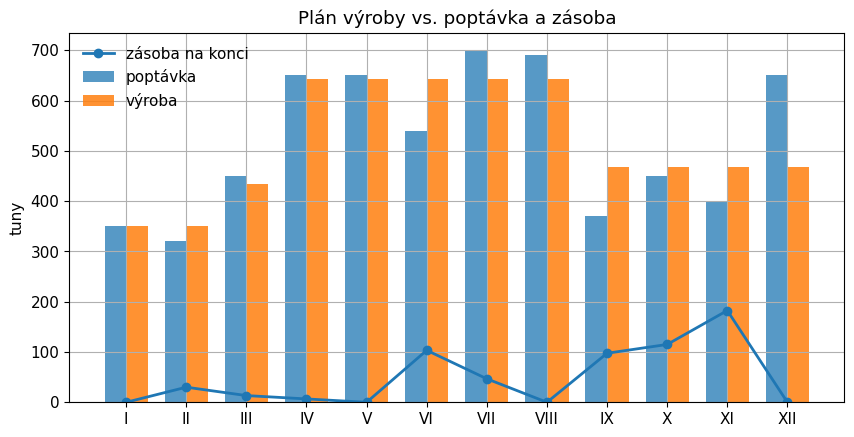

In [24]:
fig, ax = plt.subplots(figsize=(10,4.8))
w = np.arange(len(months))
ax.bar(w-0.18, demand, width=0.36, label="poptávka", alpha=0.75)
ax.bar(w+0.18, res["x"], width=0.36, label="výroba", alpha=0.85)
ax.plot(w, res["s"], marker="o", label="zásoba na konci", linewidth=2)
ax.set_xticks(w); ax.set_xticklabels(months)
ax.set_ylabel("tuny")
ax.set_title("Plán výroby vs. poptávka a zásoba")
ax.legend(frameon=False)
plt.show()

# Změny výroby
delta = np.diff(np.r_[x0, res["x"]])
fig, ax = plt.subplots(figsize=(10,3.8))
ax.bar(w, np.maximum(delta,0), width=0.5, label="zvýšení y", color="#1f77b4")
ax.bar(w, -np.minimum(delta,0), width=0.5, bottom=None, label="snížení z", color="#ff7f0e")
ax.axhline(0, color="k", linewidth=0.8)
ax.set_xticks(w); ax.set_xticklabels(months)
ax.set_ylabel("tuny změny")
ax.set_title("Změna výroby mezi měsíci (|Δx| = y+z)")
ax.legend(frameon=False)
plt.show()


## Co když je skladování „zadarmo“?

Nastavíme `holding_cost = 0`. Očekávání:
- vyplatí se **vyhladit** výrobu a držet zásoby přes měsíce s nízkou poptávkou,
- protože platíme jen za **změny výroby**, ne za držení zásob.


In [25]:
res_free = solve_icecream_lp(demand, change_cost=change_cost, holding_cost=0.0, x0=x0, s0=s0, names=months, msg=False)
print("Status:", res_free["status"])
print(f"Celkový náklad (skladování 0): {res_free['obj']:.0f} Kč")

fig, ax = plt.subplots(figsize=(10,4.8))
w = np.arange(len(months))
ax.bar(w-0.18, demand, width=0.36, label="poptávka", alpha=0.75, color="#9e9e9e")
ax.bar(w+0.18, res_free["x"], width=0.36, label="výroba (c_S=0)", alpha=0.9, color="#2ca02c")
ax.plot(w, res_free["s"], marker="o", label="zásoba (c_S=0)", linewidth=2, color="#2ca02c")
ax.set_xticks(w); ax.set_xticklabels(months)
ax.set_ylabel("tuny")
ax.set_title("Plán výroby při nulových nákladech na skladování")
ax.legend(frameon=False)
plt.show()


Status: Optimal
Celkový náklad (skladování 0): 930000 Kč


## Citlivost: jak reaguje optimum na změnu nákladů?

- Sweep `holding_cost` mezi 0…1000 Kč/t/měsíc (při pevném `change_cost`).
- Sweep `change_cost` mezi 500…2500 Kč/t (při pevném `holding_cost`).

Sledujeme: optimální **celkový náklad**, průměrnou **zásobu**, a celkovou **sumu změn** \( \sum|Δx| \).


In [26]:
def sweep_costs(demand, change_cost_vals=None, holding_cost_vals=None):
    rows = []
    if holding_cost_vals is not None:
        for cS in holding_cost_vals:
            r = solve_icecream_lp(demand, change_cost=change_cost, holding_cost=cS, x0=x0, s0=s0, names=months)
            rows.append({
                "mode":"hold",
                "holding_cost": cS,
                "change_cost": change_cost,
                "obj": r["obj"],
                "avg_inventory": r["s"].mean(),
                "sum_abs_change": np.abs(np.diff(np.r_[x0, r["x"]])).sum()
            })
    if change_cost_vals is not None:
        for cD in change_cost_vals:
            r = solve_icecream_lp(demand, change_cost=cD, holding_cost=holding_cost, x0=x0, s0=s0, names=months)
            rows.append({
                "mode":"change",
                "holding_cost": holding_cost,
                "change_cost": cD,
                "obj": r["obj"],
                "avg_inventory": r["s"].mean(),
                "sum_abs_change": np.abs(np.diff(np.r_[x0, r["x"]])).sum()
            })
    return pd.DataFrame(rows)

df_sens = sweep_costs(
    demand,
    change_cost_vals=np.arange(500, 2600, 250),
    holding_cost_vals=np.arange(0, 1100, 100)
)
df_sens.head()


mode  holding_cost  change_cost           obj  avg_inventory  \
0  hold           0.0       1500.0  9.300000e+05     222.500000   
1  hold         100.0       1500.0  1.197000e+06     222.500000   
2  hold         200.0       1500.0  1.347750e+06      49.583333   
3  hold         300.0       1500.0  1.407250e+06      49.583333   
4  hold         400.0       1500.0  1.466750e+06      49.583333   

   sum_abs_change  
0       620.00000  
1       620.00000  
2       819.16666  
3       819.16666  
4       819.16666

In [27]:
# Grafy citlivosti
fig, ax = plt.subplots(1,2, figsize=(12,4))
# hold-cost sweep
d1 = df_sens[df_sens["mode"]=="hold"].sort_values("holding_cost")
ax[0].plot(d1["holding_cost"], d1["obj"], marker="o")
ax[0].set_title("Celkový náklad vs. holding_cost")
ax[0].set_xlabel("holding_cost [Kč/t/měsíc]"); ax[0].set_ylabel("náklad [Kč]")

# change-cost sweep
d2 = df_sens[df_sens["mode"]=="change"].sort_values("change_cost")
ax[1].plot(d2["change_cost"], d2["obj"], marker="o")
ax[1].set_title("Celkový náklad vs. change_cost")
ax[1].set_xlabel("change_cost [Kč/t]"); ax[1].set_ylabel("náklad [Kč]")

plt.tight_layout(); plt.show()

# Vedlejší metriky
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(d1["holding_cost"], d1["avg_inventory"], marker="o")
ax[0].set_title("Průměrná zásoba vs. holding_cost")
ax[0].set_xlabel("holding_cost"); ax[0].set_ylabel("tuny")

ax[1].plot(d2["change_cost"], d2["sum_abs_change"], marker="o")
ax[1].set_title("Σ|Δx| vs. change_cost")
ax[1].set_xlabel("change_cost"); ax[1].set_ylabel("tuny změny")
plt.tight_layout(); plt.show()
